# Metabolomics Case Study - Initial EDA with PyOpenMS
Jonathan E. Hunter, January 2025

In [1]:
### Import Python Libraries ###
# Import basic python data and plotting libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import pyopenms and deps.
import pyopenms as oms
from pyopenms.plotting import plot_spectrum
from lxml import etree                      

In [2]:
## PyOpenMS Load in Data
# Load the mzXML files
extract = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/mzXML/extract.mzXML", extract)
blank = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/mzXML/blank.mzXML", blank)

# Print the number of spectra in each file
print(f"Extract #Spectra = {extract.getNrSpectra()}")
print(f"Blank #Spectra = {blank.getNrSpectra()}")

# Check scan polarity
extract_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in extract])
print(f"Extract spectra polarity value counts:\n {extract_acq_polarity.value_counts()}\n")
blank_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in blank])
print(f"Blank spectra polarity value counts:\n {blank_acq_polarity.value_counts()}")

Extract #Spectra = 14163
Blank #Spectra = 14158
Extract spectra polarity value counts:
 1    14163
Name: count, dtype: int64

Blank spectra polarity value counts:
 1    14158
Name: count, dtype: int64


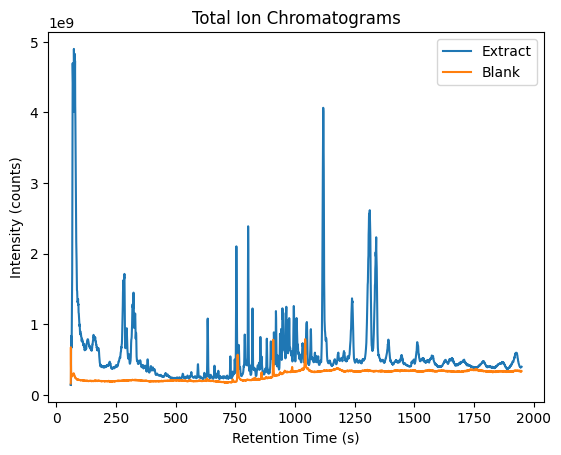

In [3]:
## PyOpenMS Generate TIC
# Extract TIC data looping over spectra in MSExperiment()
RT_extract = []
I_extract = []
for spec in extract:
    if spec.getMSLevel() == 1:
        RT_extract.append(spec.getRT())
        I_extract.append(sum(spec.get_peaks()[1]))

# Blank TIC data looping over spectra in MSExperiment()
RT_blank = []
I_blank = []
for spec in blank:
    if spec.getMSLevel() == 1:
        RT_blank.append(spec.getRT())
        I_blank.append(sum(spec.get_peaks()[1]))

# Create a pandas DataFrame
TIC_df_extract = pd.DataFrame({'RT_extract': RT_extract, 'I_extract': I_extract})
TIC_df_blank = pd.DataFrame({'RT_blank': RT_blank, 'I_blank': I_blank})

# Plot the TIC data
sns.lineplot(x=RT_extract, y=I_extract, data=TIC_df_extract, label="Extract")
sns.lineplot(x=RT_blank, y=I_blank, data=TIC_df_blank, label="Blank")
plt.title("Total Ion Chromatograms")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.show()

/home/dockeruser/venv/lib/python3.12/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))


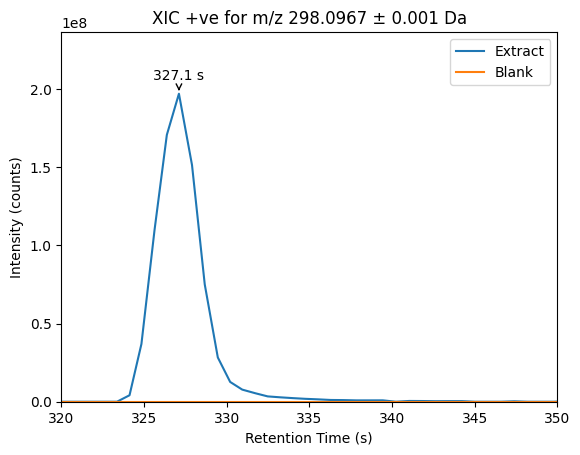

In [4]:
## PyOpenMS Generate EIC for target 298.0967 @ 327.1 s
extract_ms1 = oms.MSExperiment()
for spec in extract.getSpectra():
    if spec.getMSLevel() == 1:
        extract_ms1.addSpectrum(spec)
        
blank_ms1 = oms.MSExperiment()
for spec in blank.getSpectra():
    if spec.getMSLevel() == 1:
        blank_ms1.addSpectrum(spec)

mz_value = 298.0967
mz_window = 0.001  # Total window size (± Da)

transition = oms.ReactionMonitoringTransition()
transition.setPrecursorMZ(mz_value)
transition.setProductMZ(mz_value)  # For MS1, precursor and product m/z are the same
transition.setLibraryIntensity(1.0)
transition.setNativeID(f"XIC {mz_value}@{mz_value} +ve")

targeted_exp = oms.TargetedExperiment()
targeted_exp.addTransition(transition)

extractor = oms.ChromatogramExtractor()
extract_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    extract_ms1,  # Input experiment
    extract_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extractor = oms.ChromatogramExtractor()
blank_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    blank_ms1,  # Input experiment
    blank_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extract_xic_298_0967 = extract_298_0967.getChromatogram(0)
extract_rt, extract_intensity = extract_xic_298_0967.get_peaks()
extract_xic_298_0967_df = pd.DataFrame({'RT': extract_rt, 'Intensity': extract_intensity})
extract_xic_298_0967_df_IMax = extract_xic_298_0967_df["Intensity"].max()
extract_xic_298_0967_df_RTMax = extract_xic_298_0967_df["RT"][extract_xic_298_0967_df["Intensity"]==extract_xic_298_0967_df_IMax]

blank_xic_298_0967 = blank_298_0967.getChromatogram(0)
blank_rt, blank_intensity = blank_xic_298_0967.get_peaks()


sns.lineplot(x=extract_rt, y=extract_intensity, label="Extract")
sns.lineplot(x=blank_rt, y=blank_intensity, label="Blank")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.xlim(320, 350)
plt.ylim(0, 1.2*extract_xic_298_0967_df_IMax)
plt.annotate(f"{extract_xic_298_0967_df_RTMax.values[0].round(1)} s", [extract_xic_298_0967_df_RTMax, extract_xic_298_0967_df_IMax], textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->"))
plt.title(f"XIC +ve for m/z {mz_value} ± {mz_window} Da")
plt.show()

Found MS1 spectrum at retention time: 327.116
m/z values: [ 67.05500793  67.56723022  67.5681076  ... 700.40618896 722.24298096
 969.48858643]
Intensities: [368812.1    50700.676  80144.11  ... 128943.516  75274.53   38029.996]


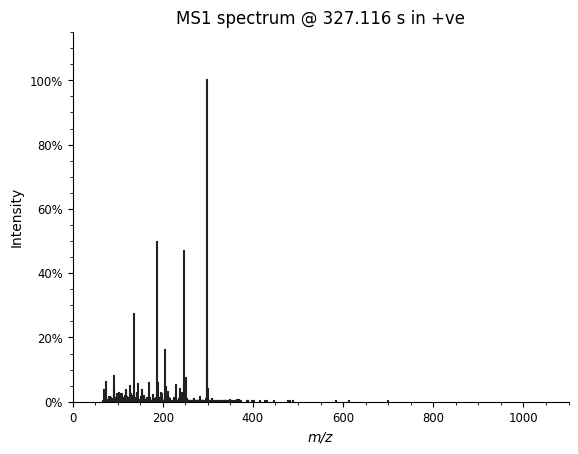

Found MS2 spectrum with precursor m/z: 298.096650065991
m/z values: [ 50.87759399  61.01138306  69.03425598  70.27145386  70.27484894
  75.02695465  76.76761627  87.4163208   94.04051208  97.02875519
 103.02152252 119.03531647 122.27677917 124.70940399 136.0617218
 137.04560852 145.03207397 163.04240417 212.5241394  246.25497437
 298.09640503 306.00265503 310.4552002 ]
Intensities: [  29493.125  636334.2     34670.797   73160.41    49341.387  258325.94
   31446.105   31080.498  113251.18   134732.27    63383.96   283832.75
   39659.844   30980.148 7878598.5    218107.6     86819.29   118088.15
   35235.973   30945.379  465111.16    30170.807   36287.965]


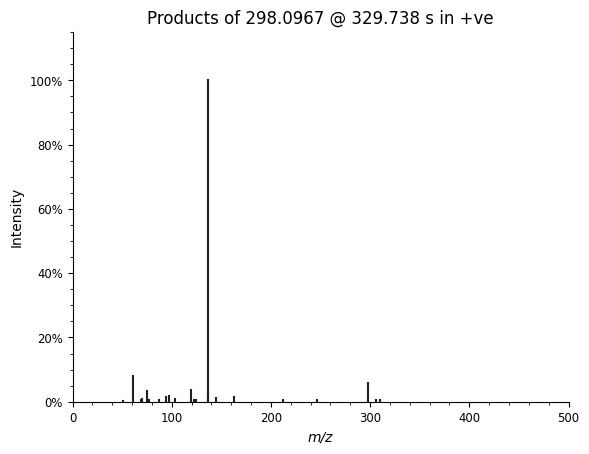

MS2 Spectrum Information:
Retention Time: 329.738
Number of Peaks: 23
Precursor m/z: 298.096650065991
Precursor Intensity: 28298092.0
50.877593994140625, 29493.125
61.011383056640625, 636334.1875
69.03425598144531, 34670.796875
70.27145385742188, 73160.40625
70.27484893798828, 49341.38671875
75.0269546508789, 258325.9375
76.76761627197266, 31446.10546875
87.41632080078125, 31080.498046875
94.04051208496094, 113251.1796875
97.02875518798828, 134732.265625
103.02152252197266, 63383.9609375
119.03531646728516, 283832.75
122.27677917480469, 39659.84375
124.70940399169922, 30980.1484375
136.0617218017578, 7878598.5
137.0456085205078, 218107.59375
145.03207397460938, 86819.2890625
163.0424041748047, 118088.1484375
212.52413940429688, 35235.97265625
246.25497436523438, 30945.37890625
298.0964050292969, 465111.15625
306.0026550292969, 30170.806640625
310.4552001953125, 36287.96484375
Collision Energy: None


In [5]:
## PyOpenMS Generate MS1 and MS2 spectra for target 298.0967 @ 327.1 s
# Desired retention time
target_rt = 327.1

# Find the MS1 spectrum closest to the target retention time
closest_spectrum = None
closest_rt_diff = float('inf')

for spectrum in extract:
    if spectrum.getMSLevel() == 1:  # Ensure it's an MS1 spectrum
        rt = spectrum.getRT()
        rt_diff = abs(rt - target_rt)
        if rt_diff < closest_rt_diff:
            closest_rt_diff = rt_diff
            closest_spectrum = spectrum

# Check if a spectrum was found
if closest_spectrum is not None:
    print(f"Found MS1 spectrum at retention time: {closest_spectrum.getRT()}")
    mz, intensity = closest_spectrum.get_peaks()
    print("m/z values:", mz)
    print("Intensities:", intensity)
else:
    print("No MS1 spectrum found close to the target retention time.")
    
plot_spectrum(closest_spectrum, annotate_ions=True)
plt.title(f"MS1 spectrum @ {np.round(closest_spectrum.getRT(), 3)} s in +ve")
plt.show()

# Find the MS2 spectrum with the precursor m/z closest to 298.0967
closest_ms2_spectrum = None
closest_mz_diff = float('inf')

for spectrum in extract:
    if spectrum.getMSLevel() == 2:  # Ensure it's an MS2 spectrum
        precursors = spectrum.getPrecursors()
        if precursors:
            precursor_mz = precursors[0].getMZ()
            mz_diff = abs(precursor_mz - mz_value)
            if mz_diff < closest_mz_diff:
                closest_mz_diff = mz_diff
                closest_ms2_spectrum = spectrum

# Check if a spectrum was found
if closest_ms2_spectrum is not None:
    print(f"Found MS2 spectrum with precursor m/z: {closest_ms2_spectrum.getPrecursors()[0].getMZ()}")
    mz, intensity = closest_ms2_spectrum.get_peaks()
    print("m/z values:", mz)
    print("Intensities:", intensity)
else:
    print("No MS2 spectrum found with the precursor m/z close to 298.0967.")
    
plot_spectrum(closest_ms2_spectrum, annotate_ions=True)
plt.title(f"Products of {np.round(closest_ms2_spectrum.getPrecursors()[0].getMZ(), 4)} @ {np.round(closest_ms2_spectrum.getRT(), 3)} s in +ve")
plt.show()

display(closest_ms2_spectrum)
# Display information about the closest MS2 spectrum
print(f"MS2 Spectrum Information:")
print(f"Retention Time: {closest_ms2_spectrum.getRT()}")
print(f"Number of Peaks: {closest_ms2_spectrum.size()}")
print(f"Precursor m/z: {closest_ms2_spectrum.getPrecursors()[0].getMZ()}")
print(f"Precursor Intensity: {closest_ms2_spectrum.getPrecursors()[0].getIntensity()}")

ms2 = pd.DataFrame({'mz': mz.tolist(), 'intensity': intensity.tolist()})
for i in range(0, len(ms2)):
    print(f"{ms2['mz'][i]}, {ms2['intensity'][i]}")
    
print(f"Collision Energy: {closest_ms2_spectrum.getInstrumentSettings().getMetaValue('collisionEnergy')}")

In [6]:
## PyOpenMS metadata extraction
# Extract scan number of the closest MS2 spectrum
scan_number_target = closest_ms2_spectrum.getNativeID()
print(f"Scan number of the closest MS2 spectrum: {scan_number_target}")

# Load the mzXML file
mzxml_file = "sync/Data/mzXML/extract.mzXML"

# Parse the XML file
tree = etree.parse(mzxml_file)
root = tree.getroot()

# Define the mzXML namespace (update this if your mzXML file uses a different namespace)
namespace = {"mzxml": "http://sashimi.sourceforge.net/schema_revision/mzXML_3.2"}

# Extract scan metadata
rows = []
for scan in root.findall(".//mzxml:scan", namespaces=namespace):
    scan_number = scan.get("num")
    ms_level = scan.get("msLevel")
    retention_time = scan.get("retentionTime")
    polarity = scan.get("polarity")
    centroided = scan.get("centroided")
    collisionEnergy = scan.get("collisionEnergy")
    lowMz = scan.get("lowMz")
    highMz = scan.get("highMz")
    basePeakMz = scan.get("basePeakMz")
    basePeakIntensity = scan.get("basePeakIntensity")
    totIonCurrent = scan.get("totIonCurrent")
    rows.append({
    'scan_number': scan_number,
    'ms_level': ms_level,
    'retention_time': retention_time,
    'polarity': polarity,
    'centroided': centroided,
    'collisionEnergy': collisionEnergy,
    'lowMz': lowMz,
    'highMz': highMz,
    'basePeakMz': basePeakMz,
    'basePeakIntensity': basePeakIntensity,
    'totIonCurrent': totIonCurrent,
    })
    for subchild in scan:
        if subchild.tag == "{http://sashimi.sourceforge.net/schema_revision/mzXML_3.2}precursorMz":
            precursorScanNum = subchild.get("precursorScanNum")
            precursorCharge = subchild.get("precursorCharge")
            precursorIntensity = subchild.get("precursorIntensity")
            activationMethod = subchild.get("activationMethod")
            windowWideness = subchild.get("windowWideness")
            precursor_mz = subchild.text
            rows[-1].update({
            'precursor_mz': precursor_mz,
            'precursorScanNum' : precursorScanNum,
            'precursorCharge': precursorCharge,
            'precursorIntensity': precursorIntensity,
            'activationMethod': activationMethod,
            'windowWideness': windowWideness,
            })
            
df = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)
df[df["scan_number"] == scan_number_target]
display(df.head())

Scan number of the closest MS2 spectrum: scan=2049


,scan_number,ms_level,retention_time,polarity,centroided,collisionEnergy,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,precursor_mz,precursorScanNum,precursorCharge,precursorIntensity,activationMethod,windowWideness
0,1,1,PT60.113S,+,1,None,67.018684387207,978.303649902344,108.0812,2.0544386e07,1.6624422e08,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,PT60.5526S,+,1,None,67.055084228516,947.077697753906,108.0812,2.1804648e07,1.7960768e08,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,PT60.9003S,+,1,None,67.055053710938,877.778198242188,108.0812,2.4255664e07,1.7447182e08,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,PT61.248S,+,1,None,67.055053710938,775.935546875,108.0812,2.4262048e07,1.7012784e08,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,PT61.5684S,+,1,None,67.055076599121,969.711853027344,74.09715671,5.1385224e07,4.343911e08,NaN,NaN,NaN,NaN,NaN,NaN
